# Basic_Plot is revised as below to make it compatible with Interactivevis.py

In [9]:
"""
This is a basic script for plotting an analysis file.

Modified from : Basic_Plot.py
"""

from collections import OrderedDict
import numpy as np
import pandas as pd
import pdb

from bokeh.plotting import figure, show, output_notebook, output_file


"""This script is just the first step in visualizing the data set. This file
comprises of the method creating an html bokeh plot and a command at the end to
implement the method
"""

def makeplot(Dataframe, Cols, minvalues):
    """Basic method to plot sensitivity anlaysis.
    This is the method to generate a bokeh plot followung the burtin example
    template at the bokeh website. For clarification, parameters refer to an
    output being measured (Tmax, C, rxn2, etc.) and stats refer to the 1st or
    total order sensitivity index.
    Inputs:
    Dataframe - Name of csv file to be read into as a panda dataframe (String)
                **Note file must be in same folder as script.**
    Cols- Names of the columns to be plotted (Array of strings)
    minvalues- Cutoff minimum for which parameters should be plotted (Array of
                floats)
    Outputs:
    Generates an html of the plot. The axis is a log scale.
    """
    # Read in csv file as panda dataframe.
    tdf = pd.read_csv(Dataframe, delimiter=' ', skipinitialspace=True,
                      engine='python')
    df = tdf
    maxval = 0
    # Remove rows which have values less than cutoff values
    for i in range(0, minvalues.size):
        df = df[df[Cols[i]] > minvalues[i]]
        if maxval < max(df[Cols[i]]):
            maxval = max(df[Cols[i]])
    df = df.dropna()

    # Create dictionary of bar colors, assume up to 3 stats are plotted
    # per parameter.
    colors = ["#0d3362", "#c64737", "black"]
    stat_color = OrderedDict()
    for i in range(0, Cols.size):
        stat_color[i] = colors[i]
    # Reset index of dataframe.
    df = df.reset_index(drop=True)

    # Sizing parameters
    width = 800
    height = 800
    inner_radius = 90
    outer_radius = 300 - 10

    # Determine wedge size based off number of parameters
    big_angle = 2.0 * np.pi / (len(df)+1)
    # Determine division of wedges for plotting bars based on # stats plotted
    small_angle = big_angle / (minvalues.size+2)

    p = figure(plot_width=width, plot_height=height, title="",
               x_axis_type=None, y_axis_type=None,
               x_range=(-420, 420), y_range=(-420, 420),
               min_border=0, outline_line_color="black",
               background_fill="#f0e1d2", border_fill="#f0e1d2")

    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    # annular wedges divided into smaller sections for bars
    angles = np.pi/2 - big_angle/2 - df.index.to_series()*big_angle
    # circular axes and labels
    labels = np.power(10.0, np.arange(0, -5, -1))
    labz = np.power(10.0, np.arange(0, -4.5, -0.5))
    # Re-size if no values are above 0.1
    if maxval < 0.1:
        labels = np.delete(labels, 0)
    # Size of radii of each label
    #pdb.set_trace()
    rad = (((np.log10(labz / labels[0])) + labels.size) *
           (outer_radius - inner_radius) / labels.size + inner_radius)
    radii = (((np.log10(labels / labels[0])) + labels.size) *
             (outer_radius - inner_radius) / labels.size + inner_radius)
    # Add zero label to labels and radii
    labels = np.append(labels, 0.0)
    radii = np.append(radii, inner_radius)
    rad = np.append(rad, inner_radius)
    p.circle(0, 0, radius=rad, fill_color=None, line_color="white")
    p.text(0, radii[:], [str(r) for r in labels[:]],
           text_font_size="8pt", text_align="center", text_baseline="middle")
    # Plot the values of each stat for each parameter.
    for c in range(0, Cols.size):
        p.annular_wedge(0, 0, inner_radius, (((np.log10(df[Cols[c]] /
                                              labels[0])) + labels.size) *
                                             (outer_radius - inner_radius) /
                                             labels.size + inner_radius),
                        -big_angle + angles + (2*c + 1)*small_angle,
                        -big_angle + angles + (2*c + 2)*small_angle,
                        color=stat_color[c])
    # radial axes
    p.annular_wedge(0, 0, inner_radius-10, outer_radius+10,
                    -big_angle+angles, -big_angle+angles, color="black")

    # Placement of parameter labels
    xr = radii[0]*np.cos(np.array(-big_angle/2 + angles))
    yr = radii[0]*np.sin(np.array(-big_angle/2 + angles))

    label_angle = np.array(-big_angle/2+angles)
    label_angle[label_angle < -np.pi/2] += np.pi
    # Placing Labels and Legend
    p.text(xr, yr, df.Parameter, angle=label_angle,
           text_font_size="9pt", text_align="center", text_baseline="middle")

    p.rect([-40, -40], [18, 0], width=30, height=13,
           color=list(stat_color.values()))
    p.text([-15, -15], [18, 0], text=Cols,
           text_font_size="9pt", text_align="left", text_baseline="middle")

    
    return p


# Code Below is the interactive plots version

In [18]:
"""
The current program is meant to draw interactive visualizations using BOKEH
and ipywidgets libraries for sensitivity analysis

Dependencies : 
Currently this code needs to be run Inside Ipython notebook.
Python version :2.7

Note:
Please ensure Basic_Plot.py exists in same directory and necessary data files are
located in c:/HDSAviz_data folder

Basically files should be organized as : 

C: HDSAviz_data/
C: HDSAviz_data/analysis_CO.txt 
C: HDSAviz_data/analysis_CO2.txt 
etc.

C: HDSAviz_data/interactivevislib.py 
C: HDSAviz_data/Interactive_vis_toolkit.ipynb

"""

#import Basic_Plot  once Basic_Plot.py file is ammended.

import os
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import output_file, output_notebook, show, vform
from ipywidgets import FloatSlider
from IPython.html.widgets import interact
from collections import OrderedDict
from bokeh.plotting import figure, show, output_notebook, output_file

# initializing the range of values for total order (ST) and first order (S1) sensitivity tests 
ST_Range = 1
S1_Range = 1

def change_directory():
    """
    This function changes the working directory from C:Users/UserName to
    C:/HDSAviz_data/ which is chosen as convention for current project.
    
    Output: 
    Changes working directory and prints current directory
    """
    path = "c:/HDSAviz_data"
    os.chdir(path)
    print 'current working directory: ' + os.getcwd()


def gather_all_analysis_files():
    """
    This function gathers all the analysis files from C:/HDSAvis_data/ 
    
    Output: 
    Returns a list of analysis files that can be fed into plotting function
    
    """
    new = !ls
    analysis_files = []
    for files in new:
        if files.startswith("analysis"):
            analysis_files.append(files)
    print 'all analysis files gathered from current directory!' 
    return analysis_files

def plot_all_outcomes_burtin(S1_Range,ST_Range): 
    """
    This function plots the burtin type plots for all the outcome 
    variables in different text files.
    
    Input :
    S1_Range: Minimum value of sensitivity for first order effects * 0.001, 
    ST_Range: Minimum value of sensitivity for total order effects * 0.001
    
    Output:
    Tab based plotting of Graphs. 
    """
    working_dir = !pwd
    if working_dir != 'C:/HDSAviz_data/' :
        change_directory()
    
    analysis_files = gather_all_analysis_files()
    tabs_dictionary = {}
    
    for i,files in zip(range(len(analysis_files)), analysis_files):
        # cleaning the file names to get a short name to occupy less space in tabs.
        names = files.replace('analysis_', '' ).replace('.txt','')
        
        try :
            tabs_dictionary[i] = Panel(child = makeplot(files, np.array(['S1', 'ST']), 
                                np.array([0.001*S1_Range, 0.001*ST_Range])),
                                title = names)    
        except:
            pass

    
    tabs = Tabs(tabs=tabs_dictionary.values())
    
    try :
        p = show(tabs)
        output_notebook()
    except:
        pass
    
    return p

def Interact_with_burtin_plots():
    """
    This function adds capability to adjust the minimum threshold for sensitiity plotting
    
    Output: 
    Interactive graph displaying a slider widgets that allow for 
    minimum threshold of sensitivity selection
    """
    output_notebook()
    slider1 = FloatSlider(value = 1, min = 0.1, max = 10, step=0.1, title = 'S1-Range')
    slider2 = FloatSlider(value = 1, min = 0.1, max = 10, step=0.1, title = 'ST-Range')
    return interact(plot_all_outcomes_burtin, S1_Range=slider1, ST_Range=slider2)

def short_tabs_demo(S1_Range,ST_Range):
    """
    This function plots the burtin type plots for two outcome 
    variables in CO and CO2.
    
    Input :
    S1_Range: Minimum value of sensitivity for first order effects * 0.001, 
    ST_Range: Minimum value of sensitivity for total order effects * 0.001
    
    Output:
    Tab based plotting of Graphs (Only two tabs for simplicity and sanity check experimentation). 
    
    """
    output_notebook()
    tab1 = Panel(child = makeplot('analysis_CO.txt', np.array(['S1', 'ST']), np.array([0.001*S1_Range, 0.001*ST_Range])), title = 'CO')
    tab2 = Panel(child = makeplot('analysis_CO2.txt', np.array(['S1', 'ST']), np.array([0.001*S1_Range, 0.001*ST_Range])), title = 'CO2')
    tabs = Tabs(tabs=[tab1,tab2])
    return show(tabs)

def short_interactive_demo ():
    """
    This function adds capability to adjust the minimum threshold for sensitiity plotting
    for demo and uses only two key factors. 
    
    Output: 
    Interactive graph displaying a slider widgets that allow for 
    minimum threshold of sensitivity selection
    """
    #output_notebook()
    slider1 = FloatSlider(value = 1, min = 0.1, max = 10, step=0.1, title = 'S1-Range')
    slider2 = FloatSlider(value = 1, min = 0.1, max = 10, step=0.1, title = 'ST-Range')
    return interact(short_tabs_demo, S1_Range = slider1, ST_Range = slider2)

# for trial runs please uncomment the following when files are in correct folder
"""
Small demo's with two outcomes(CO and CO2) plotted as tabs.
"""
# short_tabs_demo(1,1)
# short_interactive_demo()

"""
The interactive plots for all Outcomes with all outcomes as tab.
"""

print 
# plot_all_outcomes_burtin(1, 1)
# Interact_with_burtin_plots()

# The following cells can run code for demo purpose

current working directory: c:\HDSAviz_data
all analysis files gathered from current directory!



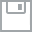
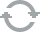
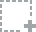
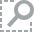
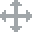
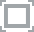
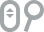
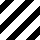
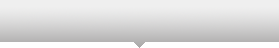
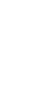
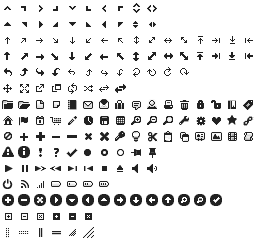
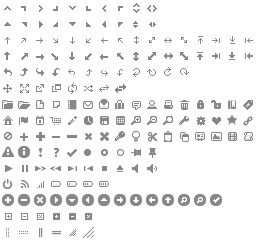
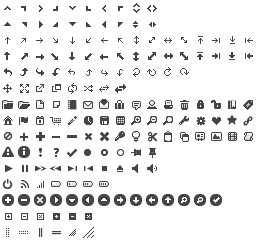
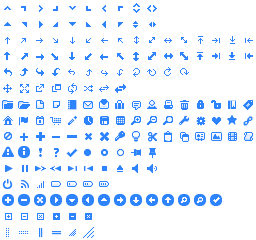
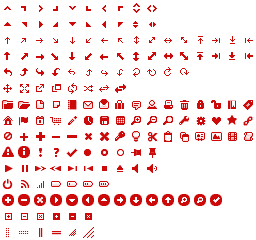
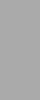
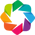
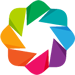

In [19]:
plot_all_outcomes_burtin(1, 1)


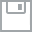
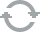
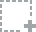
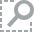
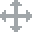
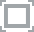
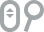
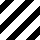
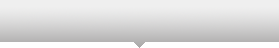
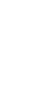
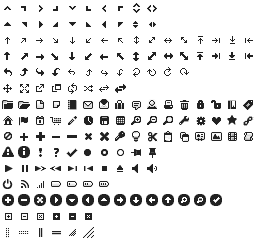
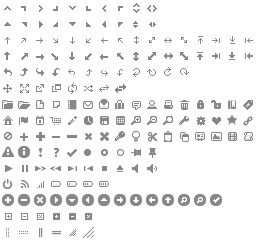
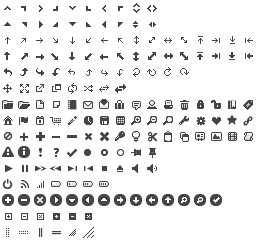
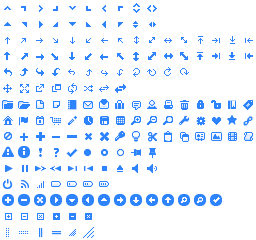
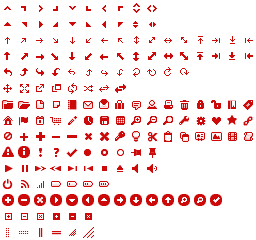
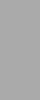
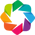
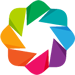

In [6]:
short_interactive_demo()

current working directory: c:\HDSAviz_data
all analysis files gathered from current directory!



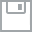
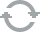
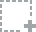
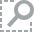
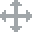
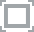
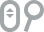
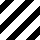
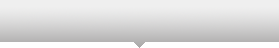
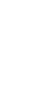
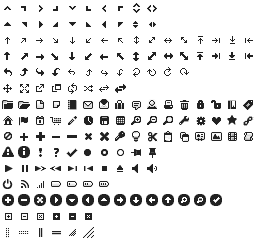
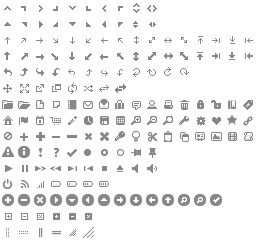
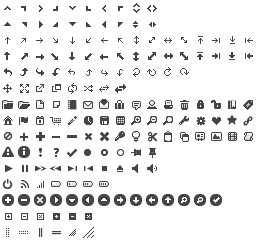
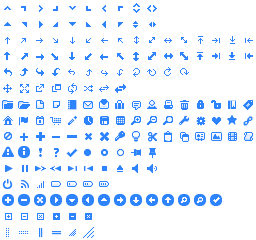
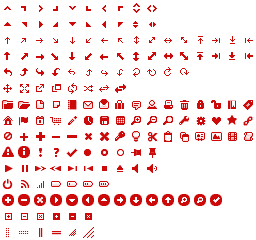
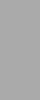
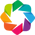
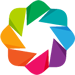

<function __main__.plot_all_outcomes_burtin>

In [7]:
Interact_with_burtin_plots()


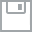
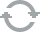
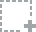
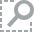
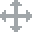
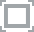
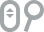
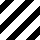
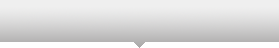
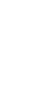
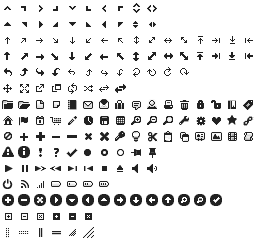
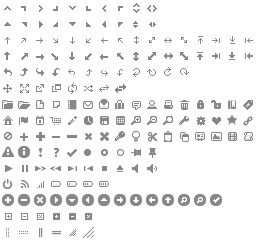
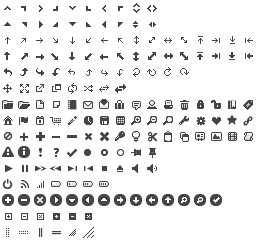
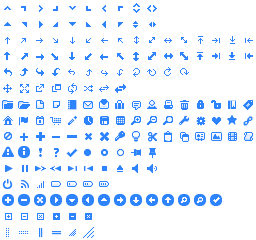
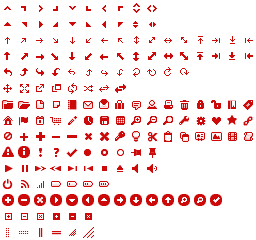
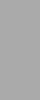
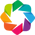
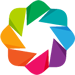

In [8]:
short_tabs_demo(1,1)